In [12]:
from __future__ import division

# import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np
import pylab
import pymongo
import seaborn as sns
import requests

In [13]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/pdarche/miniconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Constants

In [15]:
# Brigher Planet Key Info
KEY = '20f32c9fad4aebc9998f8ce569bdc358'
BASE = 'http://impact.brighterplanet.com/'

# Useful variables 
EMISSIONS_TO_DATE = 500000000000
ONEFIVE_DEG_CARBON_BUDGET_KG = 1000000000000000
TWO_DEG_CARBON_BUDGET_KG = 1330000000000000
TWOFIVE_DEG_CARBON_BUDGET_KG = 1500000000000000
DEGR_PER_TON_CARBON = 0.0000000000015
CURRENT_POPULATION = 7400000000
YEARS_TO_2100 = 84
YEARS_TO_2050 = 34
GIGATON = 1000000000000
GOV_CARBON_KGS = 121300000000
US_POP = 322000000
PERSONAL_DAY_GOV_CARBON = GOV_CARBON_KGS / US_POP / 365
TOTAL_PERSON_TRIPS = 2.2 * 10**9
CARBON_GROWTH_RATE = .03

### Chart Style Settings

In [16]:
sns.set_style('whitegrid')
sns.despine();

In [17]:
def remove_gridlines(ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

In [18]:
def modify_gridlines(ax):
    for line in ax.get_ygridlines():
        line.set_linestyle(':')

    for line in ax.get_xgridlines():
        line.set_linestyle(':')

### Read in the Data

#### Transportation Carbon

In [19]:
client = pymongo.MongoClient('localhost', 27017)
db = client.carbon

In [20]:
transports = list(db.moves2.find())

In [21]:
tdf = pd.DataFrame(transports)
tdf['startDatetime'] = tdf.startTime.apply(pd.to_datetime)
tdf['date'] = tdf.startDatetime.apply(pd.to_datetime)
tdf.index = tdf.startDatetime
tdf.sort_index(inplace=True)
tdf['cumulative'] = tdf.carbon.cumsum()

In [22]:
# from bson import ObjectId
# to_delete = tdf[tdf.startDatetime >= '2016-07-01']._id.values
# db.moves2.remove({'_id': {'$in': [ObjectId(id) for id in to_delete]}})

#### Government Carbon

In [23]:
start_date = tdf.sort_values('startDatetime').startDatetime.iloc[0]
end_date = tdf.sort_values('startDatetime').startDatetime.iloc[-1]
date_range = pd.date_range(start_date, end_date)

In [24]:
gdf = pd.DataFrame(date_range)
gdf['carbon'] = PERSONAL_DAY_GOV_CARBON
gdf.columns = ['date', 'carbon']
gdf['type'] = 'government'

#### Electricity Carbon

In [25]:
def create_series(row):
    avg_usage = [row['usage_kwh'] / row['date_range'].shape[0]]
    period_length = row['date_range'].shape[0]
    usage = avg_usage * period_length
    return pd.Series(usage, index=row['date_range']).sort_index(ascending=False)
    
# pd.Series([row['usage_kwh']] * len(list(row['date_range'])), index=row['date_range']

In [26]:
def compute_carbon_kg(kwh):
    """ Computes the kgs of carbon for kwhours """
    url = BASE + 'electricity_uses.json'
    params = {
        'energy': kwh * 3.6,
        'zip_code': '10023',
        'key': KEY
    }
    res = requests.get(url, params=params).json()
    kgs = res['decisions']['carbon']['object']['value']

    return kgs

In [27]:
electricity = pd.read_csv('../data/green_button.csv')
electricity.columns=['time_period', 'usage_kwh', 'cost']

In [28]:
electricity['time_period'] = electricity.time_period.apply(lambda d: d.split(' - '))

In [29]:
electricity['start_date'] = electricity.time_period.apply(lambda t: t[0])
electricity['end_date'] = electricity.time_period.apply(lambda t: t[1])

In [30]:
electricity['date_range'] = electricity.time_period.apply(
    lambda d: pd.date_range(d[0], d[1]))

In [31]:
# electricity['usage_ranges'] = electricity.apply(create_series, 1)
series = [create_series(row) for row in electricity.to_dict(orient='records')]
edf = pd.concat(series).reset_index()
edf.columns = ['date', 'usage_kwh']
edf['date'] = edf.date.apply(pd.to_datetime)
edf.index = edf.date
edf['type'] = 'electricity'

In [32]:
edf['carbon'] = edf.usage_kwh.apply(compute_carbon_kg)

In [33]:
test_edf = pd.DataFrame(date_range, columns=['date'])
test_edf['date'] = test_edf.date.apply(lambda d: d.strftime('%Y-%m-%d'))
test_edf.index = test_edf.date

In [34]:
merged = test_edf.join(edf, rsuffix='_y')
merged = merged.drop('date_y', 1)

In [35]:
merged.carbon.fillna(merged.carbon.mean(), inplace=True)
merged.usage_kwh.fillna(merged.usage_kwh.mean(), inplace=True)
merged.type.fillna('electricity', inplace=True)
merged['date'] = merged.date.apply(pd.to_datetime)
merged.index = merged.date
merged.sort_index(inplace=True)
edf = merged

#### Full DataFrame

In [36]:
df = pd.concat([
        tdf[['date', 'carbon', 'type']],
        edf[['date', 'carbon', 'type']],
        gdf
    ])

In [37]:
df.index = df.date
df.sort_index(inplace=True)

In [38]:
# # Lifetime cummulative carbon footprint
# ax = plt.axes()
# tdf.cumulative.plot(figsize=(18,5))
# plt.xlabel('Date')
# plt.ylabel('Total Carbon (kg)')
# plt.title('All-time Cumulative Transportation Carbon Footprint')
# ax.yaxis.grid(False)
# for row in tdf.to_dict(orient='records'):
#     if row['type'] == 'airplane':
#         plt.axvline(row['startDatetime'], color='orange', linewidth=.5)
# orange = mpatches.Patch(color='orange', label='Flights')
# plt.legend(handles=[orange])
# plt.show()
# pylab.savefig('../images/all_time_footprint.png')

In [103]:
grouped = df[(df.date >= '2014-01-01')].groupby(lambda d: d.year)

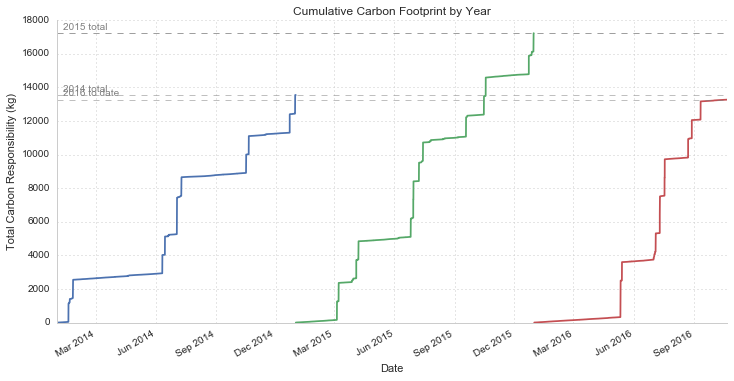

In [115]:
# Cumulative carbon footprint by year
text_x = datetime.date(2014, 1, 10)
fourteen_y = grouped.get_group(2014).carbon.sum()
fifteen_y = grouped.get_group(2015).carbon.sum()
sixteen_y = grouped.get_group(2016).carbon.sum()

ax = plt.axes()
sns.despine()
modify_gridlines(ax)

for name, group in grouped:
    group.carbon.cumsum().plot(figsize=(12,6))
plt.title('Cumulative Carbon Footprint by Year')
plt.xlabel('Date')
plt.ylabel('Total Carbon Responsibility (kg)')

plt.axhline(fourteen_y, color='gray', linewidth=.5, linestyle='--')
plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')

ax.text(text_x, fourteen_y + 200, '2014 total', fontsize=10, color='gray')
ax.text(text_x, fifteen_y + 200, '2015 total', fontsize=10, color='gray')
ax.text(text_x, sixteen_y + 200, '2016 to date', fontsize=10, color='gray')
plt.axhline(sixteen_y, color='gray', linewidth=.5, linestyle='--')

# ax.yaxis.grid(False)
# ax.xaxis.grid(False)
    
# pylab.savefig('../images/cumulative_footprint_by_year.png')

In [105]:
grouped_wo_flights = df[
    (df.type != 'airplane') &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [106]:
grouped_wo_cars = df[
    (~df.type.isin(['car', 'airplane'])) &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [107]:
grouped_wo_govt = df[
    (~df.type.isin(['car', 'airplane', 'government'])) &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [108]:
grouped_type = df[(df.date >= '2014-01-01')].groupby('type')

In [128]:
# total = df[
#     (df.index.year != 2013) &
#     (df.index.year != 2016)]
# flight_avg = flight_carbon.sum() / flight_carbon.carbon.count()
# flight_count = total[total.type=='airplane'].shape[0] / 2
# (2 * flight_avg) / ((total.carbon.sum() / 2) - (flight_avg * flight_count))
# flight_carbon = df[df.type=='airplane']
# flight = flight_carbon.carbon.sum() / 2
# total[total.type == 'airplane'].carbon.sum() / total[total.type!='airplane'].carbon.sum()

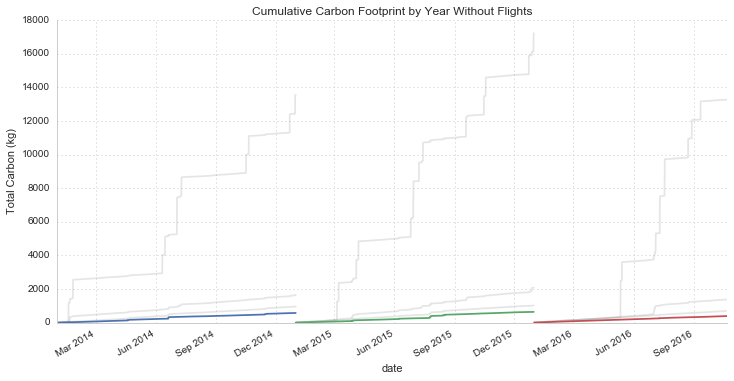

In [116]:
text_x = datetime.date(2014, 1, 10)
fourteen_y = grouped_wo_flights.get_group(2014).carbon.sum()
fifteen_y = grouped_wo_flights.get_group(2015).carbon.sum()
sixteen_y = grouped_wo_flights.get_group(2016).carbon.sum()

ax = plt.axes()
sns.despine()
modify_gridlines(ax)
# pylab.ylim([0,18000])

for name, group in grouped:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')

for name, group in grouped_wo_flights:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')
    
for name, group in grouped_wo_cars:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')
    
for name, group in grouped_wo_govt:
    group.carbon.cumsum().plot(figsize=(12,6), )    
    
plt.title('Cumulative Carbon Footprint by Year Without Flights')
plt.ylabel('Total Carbon (kg)')
# plt.xlabel('Date')

# plt.axhline(fourteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, fourteen_y + 200, '2014 total', fontsize=10, color='gray')
# plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, fifteen_y + 200, '2015 total', fontsize=10, color='gray')
# plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, sixteen_y + 200, '2016 to date', fontsize=10, color='gray')
# plt.axhline(sixteen_y, color='gray', linewidth=.5, linestyle='--')

pylab.savefig('../images/cumulative_footprint_by_year_wo_flights.png')

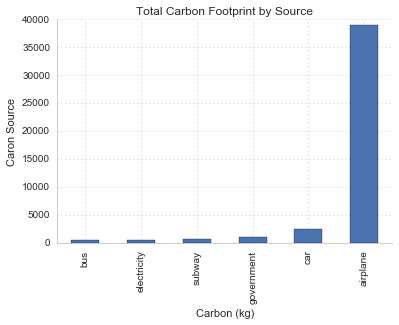

In [111]:
# Carbon distribution by transportation type
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

grouped_type.carbon.agg('sum').sort_values().plot(kind='bar')

# plt.axhline(200, color='red', linewidth=.5)
# plt.axhline(328, color='purple', linewidth=.5)
# plt.axhline(457, color='orange', linewidth=.5)

plt.title('Total Carbon Footprint by Source')
plt.xlabel('Carbon (kg)')
plt.ylabel('Caron Source')
# pylab.savefig('../images/total_footprint_by_type.png')

In [41]:
df[df.type=='airplane'].carbon.sum() / df.carbon.sum()

0.87470724759447971

In [114]:
# # Carbon distribution by transportation type
# ax = plt.axes()
# sns.despine()
# modify_gridlines(ax)

# grouped_type.carbon.agg('mean').sort_values().plot(kind='barh')
# plt.title('Average Carbon Per Trip by Source')
# plt.xlabel('Carbon (kg)')
# plt.ylabel('Transportation Type')

# # pylab.savefig('../images/avg_footprint_by_type.png')

# Where Should I Be?  What goal should I set for my carbon responsibility?

In [172]:
x = np.arange(7)
y = x * 1.5

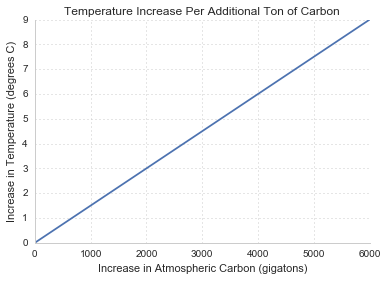

In [173]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.plot(x * 1000, y)
plt.title('Temperature Increase Per Additional Ton of Carbon')
plt.xlabel('Increase in Atmospheric Carbon (gigatons)')
plt.ylabel('Increase in Temperature (degrees C)')

# pylab.savefig('../images/temp_increase_per_ton.png')

In [415]:
avg_annual_footprint_tons = ((grouped.get_group(2015).carbon.sum() + grouped.get_group(2014).carbon.sum()) / 2) / 1000

In [416]:
generalized_annual_footprint_tons = avg_annual_footprint_tons * CURRENT_POPULATION

In [417]:
generalized_annual_gigatons = generalized_annual_footprint_tons / GIGATON

In [418]:
generalized_warming = generalized_annual_footprint_tons * DEGR_PER_TON_CARBON * YEARS_TO_2050

In [419]:
generalized_tons = generalized_annual_gigatons * YEARS_TO_2050 * 1000

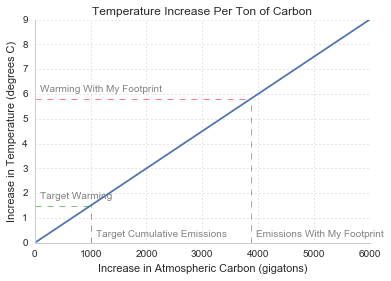

In [423]:
# Temperature increase if personal footprint was generalized
# Todo: these numbers are f'd!
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.plot(x * 1000, y)

plt.title('Temperature Increase Per Ton of Carbon')
plt.xlabel('Increase in Atmospheric Carbon (gigatons)')
plt.ylabel('Increase in Temperature (degrees C)')

plt.plot(
    [0, generalized_tons], 
    [generalized_warming, generalized_warming],
    color='red', 
    linestyle='--',
    linewidth=.5)
plt.plot(
    [generalized_tons, generalized_tons], 
    [0, generalized_warming], 
    color='red', 
    linestyle='--',
    linewidth=.5)
plt.plot([0, 1000], [1.5, 1.5], color='green', linestyle='--', linewidth=.5)
plt.plot([1000, 1000], [0, 1.5], color='green', linestyle='--', linewidth=.5)

# Plot text
ax.text(100, generalized_warming + .3, 'Warming With My Footprint', fontsize=10, color='gray')
ax.text(100, 1.8, 'Target Warming', fontsize=10, color='gray')
ax.text(generalized_tons + 100, .25, 'Emissions With My Footprint', fontsize=10, color='gray')
ax.text(1100, .25, 'Target Cumulative Emissions', fontsize=10, color='gray')

# pylab.savefig('../images/temp_increase_with_targets.png')
# pylab.savefig('../images/temp_increase_target_only.png')

In [29]:
# Temperature increase if personal footprint was generalized
# Todo: these numbers are f'd!
# ax = plt.axes()
# sns.despine()
# modify_gridlines(ax)

# plt.plot(tons, temp_change)
# plt.title('Temperature Increase Per Ton of Carbon')
# plt.xlabel('Personal Carbon Footprint (metric tons)')
# plt.ylabel('Temperature Increase (degrees C)')
# plt.plot(
#     [0, twenty_fifteen_tons], 
#     [personal_temp_change, personal_temp_change], 
#     color='red', 
#     linestyle='--',
#     linewidth=.5)
# plt.plot(
#     [twenty_fifteen_tons, twenty_fifteen_tons], 
#     [0, personal_temp_change], 
#     color='red', 
#     linestyle='--',
#     linewidth=.5)
# plt.plot([0, target_tons], [2, 2], color='green', linestyle='--', linewidth=.5)
# plt.plot([target_tons, target_tons], [0, 2], color='green', linestyle='--', linewidth=.5)
# pylab.savefig('../images/temp_increase_with_targets.png')

- [Carbon Targets - Your Footprint](http://shrinkthatfootprint.com/carbon-targets-for-your-footprint)

### Personal Carbon Quota

In [174]:
pop = pd.read_csv('../data/Kremer_CSV_WorldPop_MillionYears.csv')

In [180]:
pop_estimate = pop[(pop.year >= 2010) & (pop.year <= 2050)][
    ['year', 'World Population 1950-2013 (US Census)', 
     'UN Projection (Medium) - 2012 Revision']]

In [181]:
vals = pop_estimate.max(axis=1) * 1000000
vals.index = pop_estimate.year

### Overall Quota

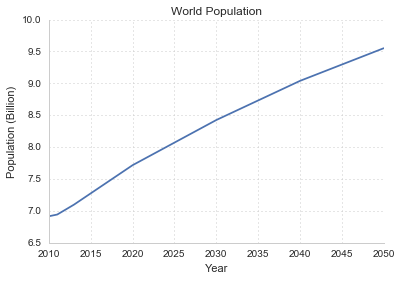

In [182]:
# World Population Data: https://esa.un.org/unpd/wpp/
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

(vals / 1000000000).plot()
plt.title('World Population')
plt.ylabel('Population (Billion)')
plt.xlabel('Year')
pylab.savefig('../images/world_pop.png')

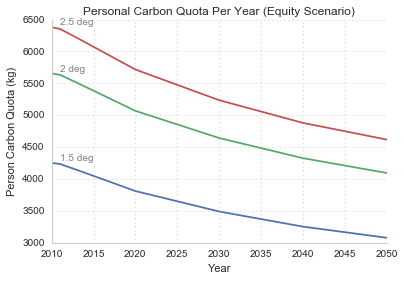

In [185]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

onefive = ((ONEFIVE_DEG_CARBON_BUDGET_KG / 34) / vals)
two = (TWO_DEG_CARBON_BUDGET_KG / 34 / vals)
twofive = (TWOFIVE_DEG_CARBON_BUDGET_KG / 34 / vals)

onefive.plot()
two.plot()
twofive.plot()

# titles & axes
plt.title('Personal Carbon Quota Per Year (Equity Scenario)')
plt.ylabel('Person Carbon Quota (kg)')
plt.xlabel('Year')

# label the pathways
ax.text(2011, onefive[2010] + 40, '1.5 deg', fontsize=10, color='gray')
ax.text(2011, two[2010] + 40, '2 deg', fontsize=10, color='gray')
ax.text(2011, twofive[2010] + 40, '2.5 deg', fontsize=10, color='gray')

# pylab.savefig('../images/personal_carbon_quota.png')

### Historical Carbon

In [186]:
# Data: https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:17975
full_ice_core = pd.read_csv(
    '../data/antarctic_ice_cores_revised_800k_yr_co2.csv')

In [187]:
full_ice_core.index = full_ice_core.age_gas_calBP

In [188]:
full_ice_core['age_gas_cal_Greg'] = np.abs(full_ice_core.age_gas_calBP - 1950)

In [189]:
full_ice_core['co2_gt'] = full_ice_core.co2_ppm * 7.76

In [190]:
# full_ice_core.head()

In [191]:
# full_ice_core.sort_values('age_gas_calBP').age_gas_cal_Greg

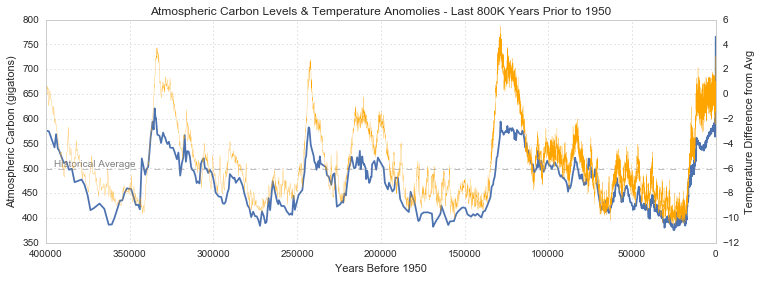

In [194]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)
text_x = 395000

historical_carbon = full_ice_core[full_ice_core.age_gas_calBP <= 400000]
((historical_carbon
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm * 2.08).plot(figsize=(12,4)))
hist_avg = historical_carbon.co2_ppm.mean() * 2.08

plt.title('Atmospheric Carbon Levels & Temperature Anomolies - Last 800K Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (gigatons)')
plt.axhline(hist_avg, color='gray', linewidth=.5, linestyle='--')
ax.text(text_x, hist_avg + 5, 'Historical Average', fontsize=10, color='gray')

ax2 = ax.twinx()
plt.ylabel('Temperature Difference from Avg')
(historic_temp[historic_temp.Age < 400000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.25, color='orange'))
remove_gridlines(ax2)
# sns.despine()

# pylab.savefig('../images/historical_carbon_800k.png')

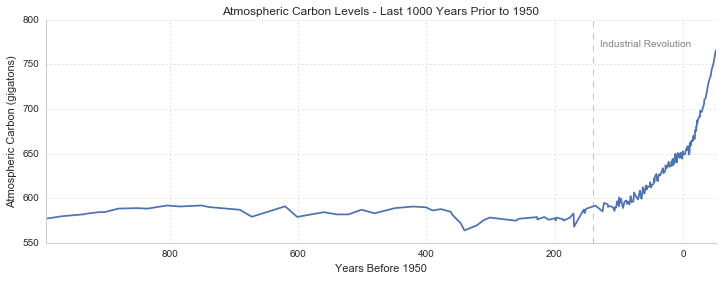

In [195]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

# Plot
((full_ice_core[full_ice_core.age_gas_calBP <= 1000]
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm * 2.08).plot(figsize=(12,4)))

# Axix labels and additional glyphs
plt.title('Atmospheric Carbon Levels - Last 1000 Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (gigatons)')
ax.text(130, 770, 'Industrial Revolution', fontsize=10, color='gray')
plt.axvline(140, color='gray', linewidth=.5, linestyle='--')

# pylab.savefig('../images/historical_carbon_1k.png')

In [196]:
original = full_ice_core[full_ice_core.age_gas_calBP <= 140].iloc[-1].co2_ppm
current = full_ice_core[full_ice_core.age_gas_calBP <= 140].iloc[0].co2_ppm
difference = current - original
perc_change = difference / original
print("Perc Changed: {}".format(perc_change))

Perc Changed: 0.29388601764933364


### Historic temperature

In [79]:
historic_temp = pd.read_csv('../data/historic_temp.csv')

In [80]:
historic_temp.index = historic_temp.Age

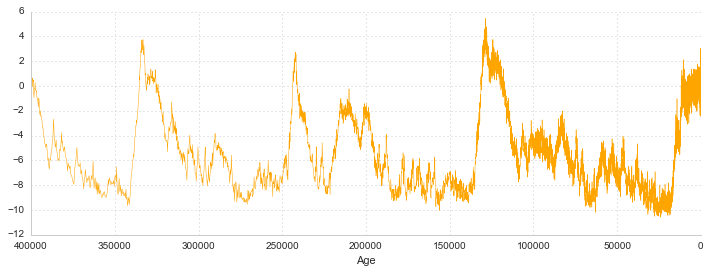

In [81]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

(historic_temp[historic_temp.Age < 400000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.5, color='orange'))

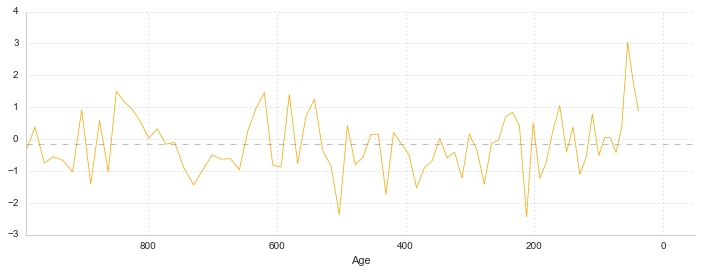

In [87]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

(historic_temp[historic_temp.Age < 1000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.75, color='orange'))

plt.axhline(
    historic_temp[historic_temp.Age < 1000].Temperature.mean(), 
    linestyle='--', 
    linewidth=.5,
    color='gray')

### Avg temperature since industrialization

In [204]:
avg_temp = pd.read_csv('../data/GLB.Ts+dSST.csv')

In [205]:
avg_temp.index = avg_temp.Year

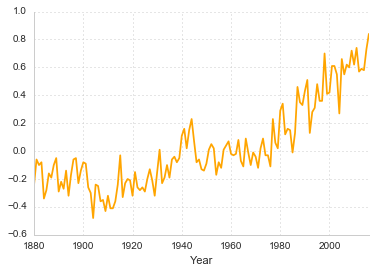

In [206]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)
avg_temp.Jul.plot(color='orange')

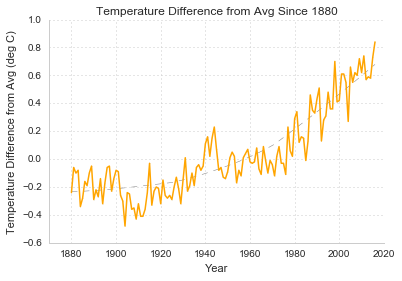

In [208]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

sns.regplot(avg_temp.Year, avg_temp.Jul, 
            lowess=True, color='gray', 
            line_kws={'linewidth': .5, 'linestyle': '--'}, scatter_kws={'s': .1})
avg_temp.Jul.plot(color='orange', linewidth=1.5)
pylab.xlim([1870,2020])
plt.title('Temperature Difference from Avg Since 1880')
plt.xlabel('Year')
plt.ylabel('Temperature Difference from Avg (deg C)')

pylab.savefig('../images/temp_diff_from_avg_1880.png')

In [212]:
# j = avg_temp[avg_temp.Year > 1960].Jul
# avg_wrm = (j - j.shift(1)).mean()

In [211]:
arr = [0] * 34
arr[0] = avg_temp.Jul.max()

In [338]:
for ix, val in enumerate(arr):
    if ix < len(arr) - 1:
        next_year_val = arr[ix] + (avg_wrm * arr[ix])
        arr[ix+1] = next_year_val

### Anthropogenic Carbon Emissions

In [10]:
anthrocarbon = pd.read_csv('../data/anthro_carbon.csv')
anthrocarbon.columns = [c.lower() for c in anthrocarbon.columns]
anthrocarbon.index = anthrocarbon.year

In [11]:
anthrocarbon = anthrocarbon[anthrocarbon.year > 1870]

In [12]:
# Compensate for missing co2?
carbon_diff = ((545000 * 3.667) - anthrocarbon.total.sum()) / anthrocarbon.shape[0]
anthrocarbon.total = anthrocarbon.total + 3999

In [13]:
hist_avg_growth = anthrocarbon.total.pct_change().mean()

In [14]:
current_total = (anthrocarbon.total / 3.667).cumsum().iloc[-1]

In [15]:
# projected_dates = np.array([2013] * 87) + np.array(range(87))
# projected_values = pd.Series(arr, index=projected_dates)

#### Emissions projections to 2100 at various emissions growth rates

In [16]:
def create_cumulative_co2_series(years, base, growth_rate):
    total = 0
    totals = []
    for g in range(87):
        total += base + (base * growth_rate)
        totals.append(total)
    return totals

In [17]:
def create_co2_series(years, base, growth_rate):
    prev_total = base
    totals = []
    for g in range(years):
        total = prev_total + (prev_total * growth_rate)
        totals.append(total)
        prev_total = total
    return totals

In [18]:
def _create_co2_series(years, base, growth_rate):
    totals = [0] * years
    totals[0] = base
    for ix, val in enumerate(totals):
        if ix < len(arr) - 1:
            next_year_val = totals[ix] + (growth_rate * totals[ix])
            arr[ix+1] = next_year_val
    return pd.Series(arr)

In [19]:
def create_c_timeseries(years, base, growth_rate):
    new_values = create_co2_series(years, base, growth_rate)
    new_dates = np.array([2013] * years) + np.array(range(1, years+1)) 
#     new_series = pd.Series(new_values, index=new_dates)
    new_series = pd.concat([
        anthrocarbon.total,
        pd.Series(new_values, index=new_dates)
    ])
    return new_series / 3.667

In [20]:
base = anthrocarbon.total.iloc[-1]

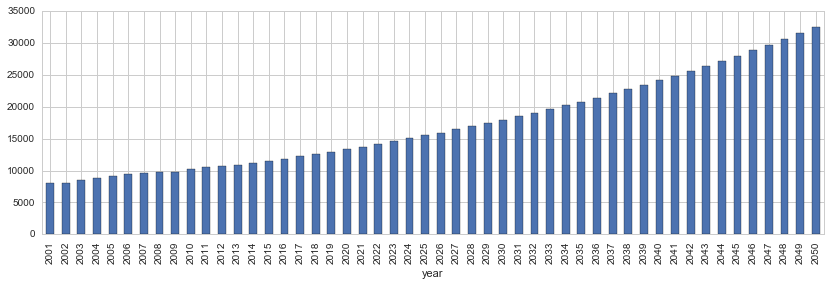

In [23]:
status_quo_emissions[status_quo_emissions.index > 2000][:50].plot(kind='bar', figsize=(14,4))

In [58]:
# # Plot setup
# ax = plt.axes()
# sns.despine()
# modify_gridlines(ax)
# safe_emissions[safe_emissions.index > 2000][:80].plot(kind='bar',figsize=(14,4))

##### Projected Emissions

In [25]:
# Status quo emissions
status_quo_emissions = create_c_timeseries(87, base, .03)

(0, 7000)

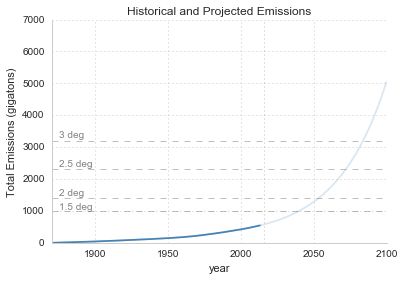

In [26]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')

(status_quo_emissions / 1000).cumsum().plot(alpha=.2, color='steelblue')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')


# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Historical and Projected Emissions')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])

# pylab.savefig('../images/historical_and_projected_emissions.png')

##### Projected Emissions with Reductions

In [27]:
flights = .02 / YEARS_TO_2050
housing = .1 / YEARS_TO_2050
meat = .05 / YEARS_TO_2050
REDUCTIONS = flights + housing + meat
reduction_emissions = create_c_timeseries(
    87, base, CARBON_GROWTH_RATE - REDUCTIONS)

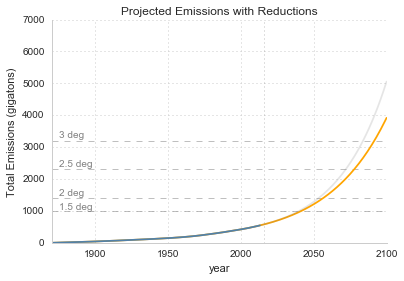

In [28]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')


(reduction_emissions / 1000).cumsum().plot(color='orange')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')
(status_quo_emissions / 1000).cumsum().plot(alpha=.2, color='gray')

# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Projected Emissions with Reductions')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])

pylab.savefig('../images/projected_emissions_with_reductions.png')

##### Projected Emissions with Efficiency Gains

In [29]:
vehicles = .04 / YEARS_TO_2050
buildings = .05 / YEARS_TO_2050
manufacturing = .04 / YEARS_TO_2050
EFFICIENCY = vehicles + buildings + manufacturing

efficiency_gains_emissions = create_c_timeseries(
    87, base, CARBON_GROWTH_RATE - REDUCTIONS - EFFICIENCY)

# efficiency_gains_emissions = create_c_timeseries(87, .6 * base, .013)

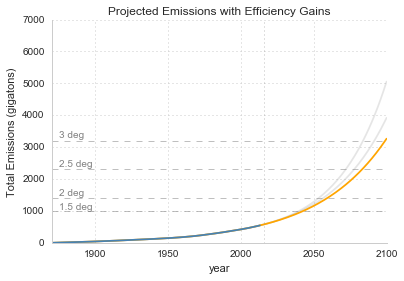

In [30]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')


(status_quo_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(reduction_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(efficiency_gains_emissions / 1000).cumsum().plot(color='orange')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')


# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Projected Emissions with Efficiency Gains')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])
pylab.savefig('../images/projected_emissions_with_efficiencies.png')

##### Projected Emissions with Renewable Energy

In [41]:
miracle = 1 / YEARS_TO_2050
MIRACLE = miracle

miracle_emissions = create_c_timeseries(
    87, base, CARBON_GROWTH_RATE - REDUCTIONS - EFFICIENCY - MIRACLE)

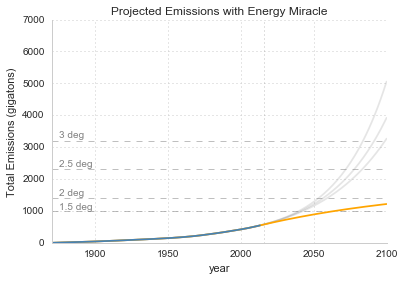

In [55]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')

(status_quo_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(reduction_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(efficiency_gains_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
# (reforestation_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(miracle_emissions / 1000).cumsum().plot(color='orange')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')

# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Projected Emissions with Energy Miracle')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])

pylab.savefig('../images/projected_emissions_with_miracle.png')

##### Projections Emissions with Reforestation

In [53]:
stop_deforestation = .18 / YEARS_TO_2050
reforestation = .005
REFORESTATION = stop_deforestation + reforestation

reforestation_emissions = create_c_timeseries(
    87, base, CARBON_GROWTH_RATE - REDUCTIONS - EFFICIENCY - MIRACLE - REFORESTATION)
# efficiency_gains_emissions = create_c_timeseries(87, .6 * base, .013)

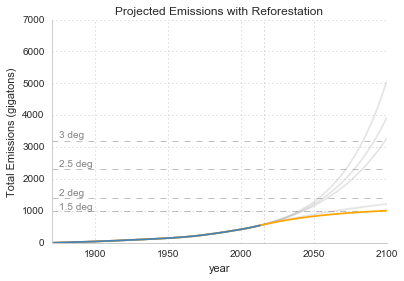

In [56]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')

(status_quo_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(reduction_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(efficiency_gains_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(miracle_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(reforestation_emissions / 1000).cumsum().plot(color='orange')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')

# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Projected Emissions with Reforestation')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])

pylab.savefig('../images/projected_emissions_with_reforestation.png')

##### Safe Emissions

In [114]:
safe_emissions = create_c_timeseries(87, base, -.07)

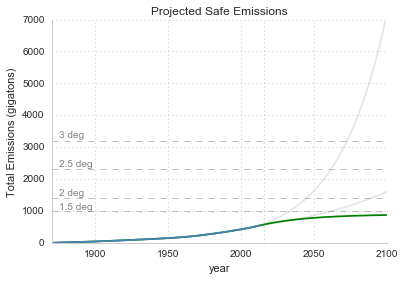

In [178]:
# Plot setup
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')


(efficiency_gains_emissions / 1000).cumsum().plot(alpha=.2, color='gray')
(safe_emissions / 1000).cumsum().plot(color='green')
(anthrocarbon.total.cumsum() / 3.667 / 1000).plot(color='steelblue')
(projected_values / 1000).plot(alpha=.2, color='gray')


# Additional informational marks
plt.axvline(2016, linestyle=':', linewidth=.5, color='gray')

# Title and Labels
plt.ylabel('Total Emissions (gigatons)')
plt.title('Projected Safe Emissions')

pylab.xlim([1870,2100])
pylab.ylim([0,7000])

pylab.savefig('../images/projected_emissions_safe.png')

In [241]:
def growth_chart(growth_rate):
    totals = create_series(growth_rate)
    pd.Series(totals).cumsum().plot()

In [242]:
# interact(growth_chart, min=-1, max=1, step=.01, growth_rate=avg_growth)

#### Average growth rate of emissions since industrialization

In [243]:
indus = full_ice_core[full_ice_core.age_gas_calBP <= 190]

In [244]:
dppm = ((indus.co2_ppm - indus.co2_ppm.shift(-1)) / indus.co2_ppm) * 100

## What can we do to get there

In [44]:
thirteen = anthrocarbon.iloc[-1].total

In [40]:
TOTAL_PERSON_TRIPS / US_POP

6.832298136645963

In [41]:
LBS_BEEF = (128.9 * 10**9)
LBS_PER_KG = 0.453592

In [45]:
((LBS_BEEF * LBS_PER_KG) / GIGATON)

1.4672908917557677e-06

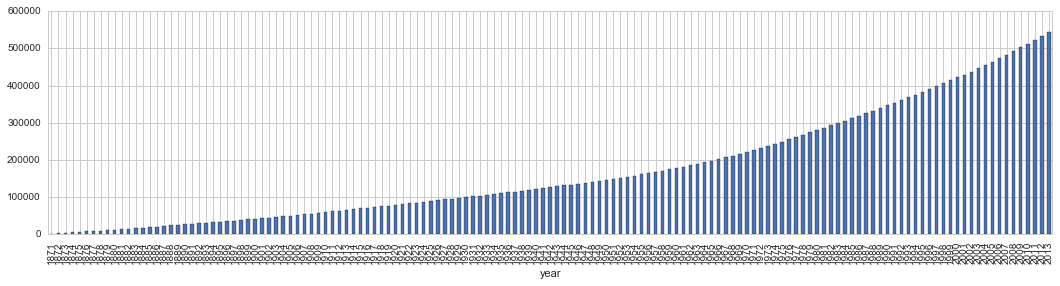

In [77]:
(anthrocarbon.total / 3.667).cumsum().plot(kind='bar', figsize=(18,4))